In [ ]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [ ]:
# Connecting to my Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Accessing files in Google Drive
# "casefiles" is the link to the 5 first cases given by ISS
# "pathToFiles" is the link to the documents we want to search. Here is the legal document

pathToFiles = "/content/gdrive/My Drive/Dataset/Omdena/wiki_sentences_v2.csv"

In [ ]:
# import wikipedia sentences
candidate_sentences = pd.read_csv(pathToFiles)
candidate_sentences.shape

(4318, 1)

In [ ]:
candidate_sentences['sentence'].head(10)

0                               confused and frustrated, connie decides to leave on her own.
1                                          later, a woman’s scream is heard in the distance.
2                                                   christian is then paralyzed by an elder.
3                                                                 the temple is set on fire.
4                                                          outside, the cult wails with him.
5                                           it's a parable of a woman's religious awakening—
6                                           c. mackenzie, and craig vincent joined the cast.
7          later, craig di francia and action bronson were revealed to have joined the cast.
8    sebastian maniscalco and paul ben-victor were later revealed as being part of the cast.
9                                                            we just tried to make the film.
Name: sentence, dtype: object

In [ ]:
doc = nlp("confused and frustrated, connie decides to leave on her own.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

confused ... advcl
and ... cc
frustrated ... conj
, ... punct
connie ... nsubj
decides ... ROOT
to ... aux
leave ... xcomp
on ... prep
her ... poss
own ... pobj
. ... punct


**Entity Pairs Extraction**

In [ ]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [ ]:
get_entities("confused and frustrated, connie decides to leave on her own.")

['connie', 'own']

In [ ]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:43<00:00, 99.91it/s] 


In [ ]:
entity_pairs[0:10]

[['connie', 'own'],
 ['later  woman', 'distance'],
 ['christian', 'then  elder'],
 ['temple', 'fire'],
 ['outside  cult', 'him'],
 ['it', 'religious  awakening'],
 ['c. mackenzie', 'craig cast'],
 ['later craig di francia', 'action cast'],
 ['sebastian  maniscalco', 'later paul ben cast'],
 ['we', 'just  film']]

**Relation/Predicate Extraction**

In [ ]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [ ]:
get_relation("John completed the task")

'completed'

In [ ]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:41<00:00, 104.13it/s]


In [ ]:
pd.Series(relations).value_counts()[:50]

is               370
was              297
released on       87
include           73
are               71
were              71
released          40
's                38
composed by       35
has               31
have              31
became            31
become            29
released in       27
included          26
produced          22
called            22
made              20
had               20
considered        20
been              18
be                18
scheduled         17
used              17
directed by       16
stars             16
written by        15
set               14
wrote             14
hired             14
produced by       14
introduced in     13
went              13
received          13
wanted            12
began in          11
won               11
began             11
gave              10
features          10
sold              10
opened             9
shot in            9
reported           9
includes           9
produced in        9
gives              9
directed     

**Build a Knowledge Graph**

In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})


In [ ]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())


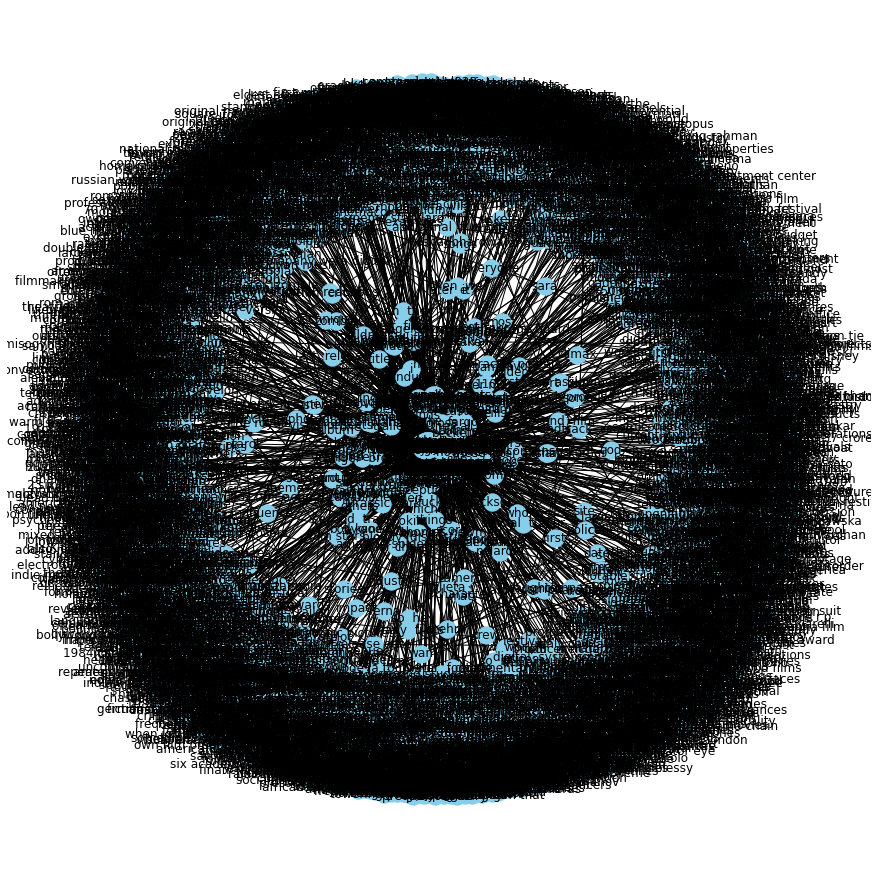

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

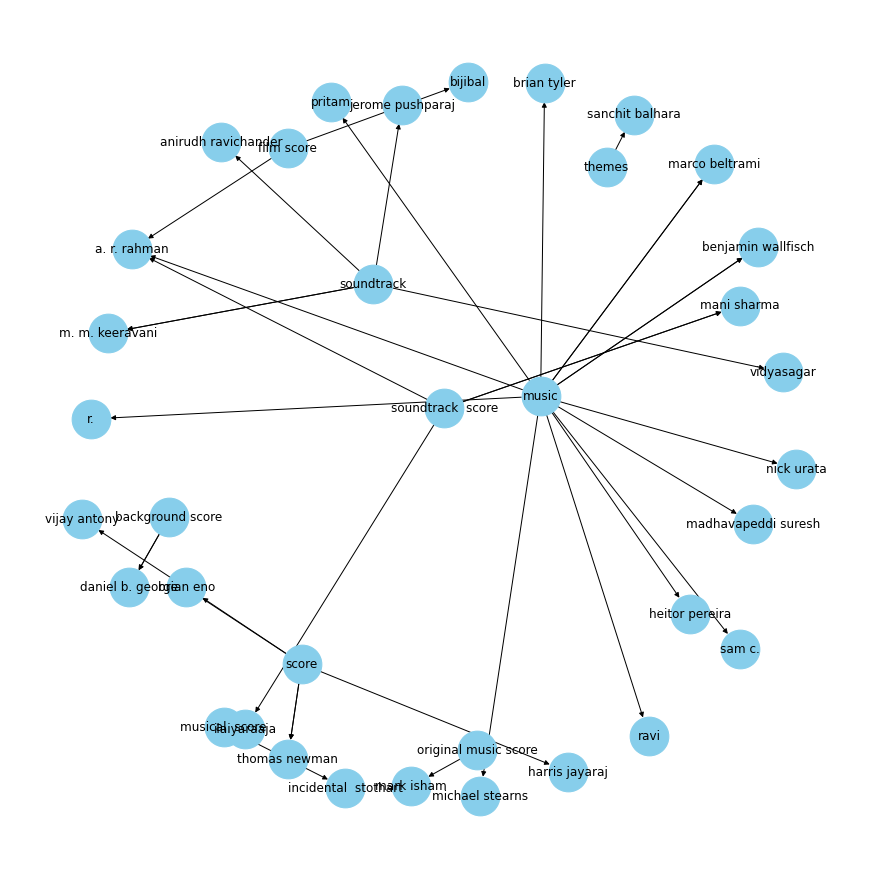

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

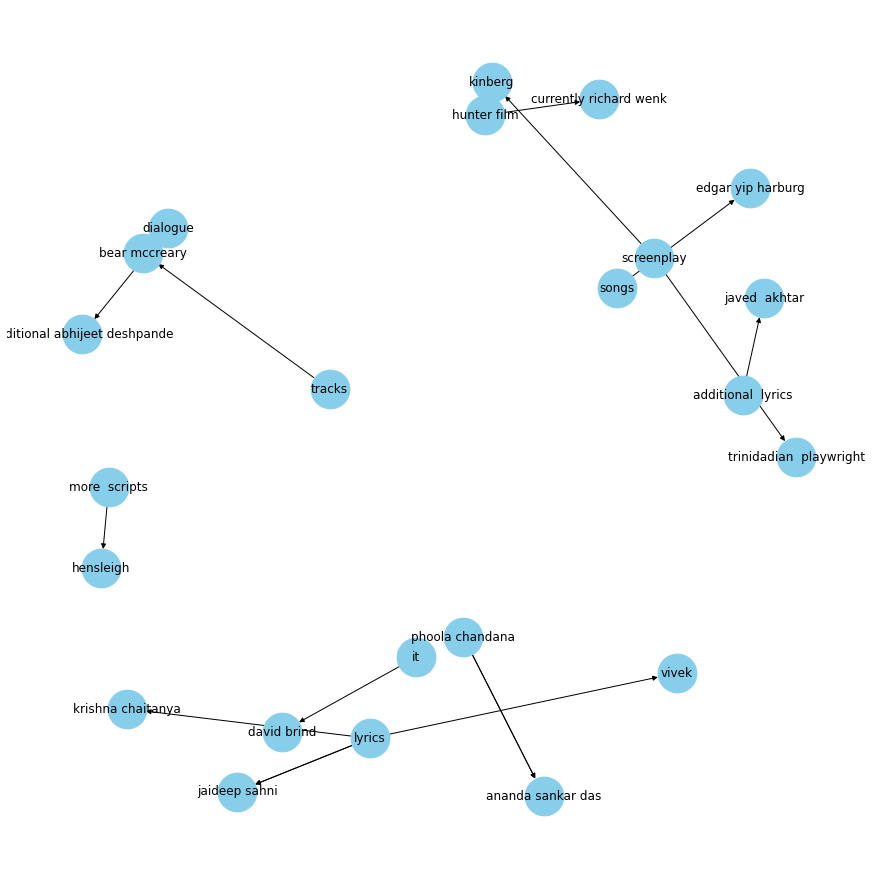

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

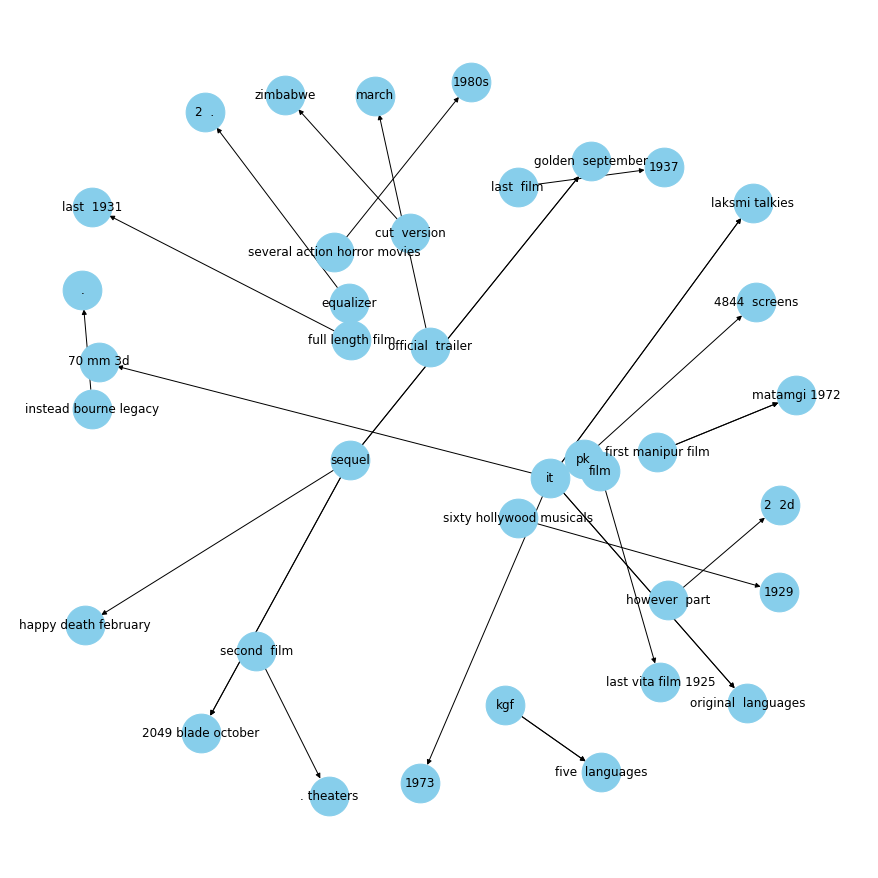

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [ ]:
# https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/

